In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from einops import rearrange, repeat
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

import utils
from utils import (
    permute_image,
    topk_acc,
    invert_permutation,
    hungarian_refine,
    visualize_errors,
)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
ckpt_path = 'logs/duj9f3yt-729-e60.ckpt'
# ckpt_path = 'logs/kf2x907t-484-ep78.ckpt'

vit_trainer = VitTrainer.load_from_checkpoint(ckpt_path)
vit_trainer = vit_trainer.to(device)

cfg = vit_trainer.cfg
vit = vit_trainer.model.eval()
dataset = ImageDataset(cfg.data_dir, cfg.image_paths_pkl)
# dataset = ImageDataset(
#    '/compute/babel-4-1/yusenh/OpenImagesV7/validation', cfg.image_paths_pkl
# )

In [ ]:
## TS

# idx = 50398  # easy car

# degenerate example with large black background
# (maybe not good demo, because people might ask why the recovered image couldn't be
# translated elsewhere).
# idx = 133863

# idx = 90186  # almost uniform texture
idx = 153060  # large white sky
# idx = 39549  # overexposed van
# idx = 8583  # weird visualization error: white patches aren't labeled as wrong. (fixed?)
# idx = 79616  # easy bird
# idx = 13553  # pond with white sky
# idx = 27528 # easy city skyline
# idx = 446944 # black and white image

# idx = 129884 # white bg wall

## VS

# idx = 6103 # easy grocery store
# idx = 19017 # hard image of a room
# idx = 26088 # hard parachute blue sky
# idx = 31971 # bad failure (almost no stuff in the image)

Selected index: 89479
Image size: 432


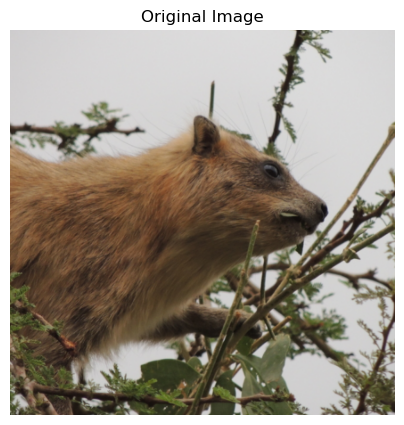

In [24]:
idx = randint(0, len(dataset) - 1)
# idx = 153060

orig_image = vit_trainer.resize_image(dataset[idx])

print(f'Selected index: {idx}')
print(f'Image size: {orig_image.shape[1]}')

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Original Image')
ax.axis('off')
ax.imshow(orig_image.permute(1, 2, 0))
plt.show()

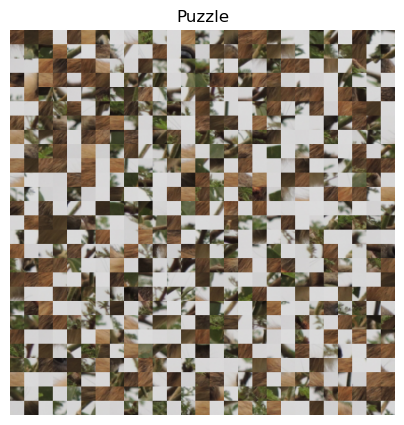

In [25]:
perm_image, perm = permute_image(orig_image.clone(), patch_size=cfg.patch_size)
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Puzzle')
ax.axis('off')
ax.imshow(perm_image.permute(1, 2, 0))
plt.show()

In [26]:
with torch.inference_mode():
    x = perm_image.unsqueeze(0).to(device)
    x = vit_trainer.norm_image(x)
    pred_perm_logits = vit(x)
    pred_perm = pred_perm_logits.squeeze().argmax(dim=-1)

In [27]:
gt = vit_trainer.gt_single[:, perm].expand(pred_perm_logits.size(0), -1)
gt_perm = gt.squeeze()
t1_acc = topk_acc(pred_perm_logits, gt, k=1)
t5_acc = topk_acc(pred_perm_logits, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.8395
Top-5 accuracy: 0.9053


In [28]:
# Raw reconstruction
inv_perm = invert_permutation(pred_perm, allow_degenerate=True)
recon_image, _ = permute_image(
    perm_image.clone(), cfg.patch_size, inv_perm, allow_degenerate=True
)

err = visualize_errors(recon_image, cfg.patch_size, pred_perm, gt_perm, alpha=0.4)

# Refined reconstruction
refined_pred_perm = hungarian_refine(pred_perm_logits.squeeze())

refined_inv_perm = invert_permutation(refined_pred_perm)
refined_recon_image, _ = permute_image(perm_image, cfg.patch_size, refined_inv_perm)
refined_err_image = visualize_errors(
    refined_recon_image, cfg.patch_size, refined_pred_perm, gt_perm
)

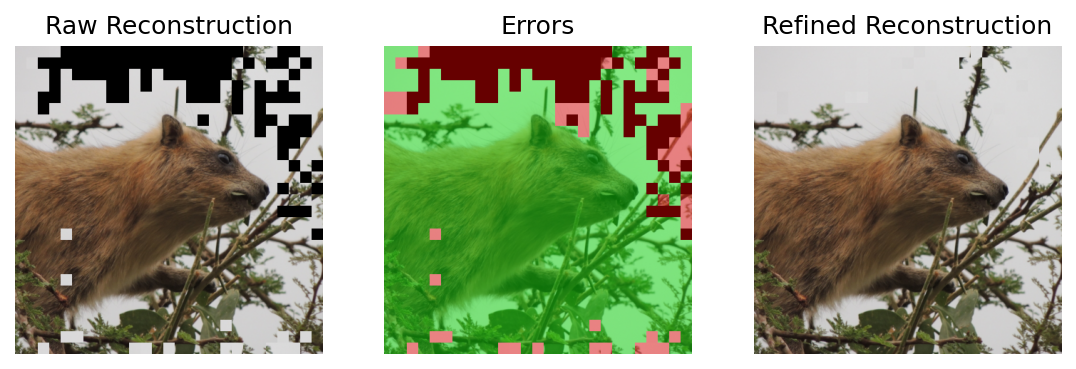

In [29]:
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
a1.set_title('Raw Reconstruction')
a1.axis('off')
a1.imshow(recon_image.permute(1, 2, 0))
a2.set_title('Errors')
a2.axis('off')
a2.imshow(err)
a3.set_title('Refined Reconstruction')
a3.axis('off')
a3.imshow(refined_recon_image.permute(1, 2, 0))
plt.show()

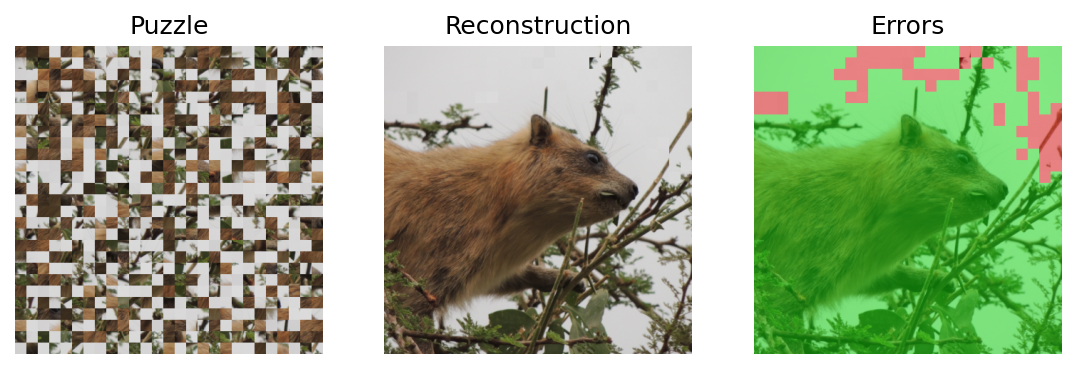

In [30]:
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
a1.set_title('Puzzle')
a1.axis('off')
a1.imshow(perm_image.permute(1, 2, 0))
a2.set_title('Reconstruction')
a2.imshow(refined_recon_image.permute(1, 2, 0))
a2.axis('off')
a3.set_title('Errors')
a3.imshow(refined_err_image)
a3.axis('off')
plt.show()